In [5]:
# imports.py
from imports import *
# custom mods
import tidy

In [2]:
import nltk
import pandas as pd
import numpy as np
from env import *

import tweepy as tw 
import scipy.stats as stats

In [6]:
df=tidy.explore_df()

cached csv


In [16]:
df.index.min()

Timestamp('2014-09-17 00:00:00+0000', tz='UTC')

In [17]:
df.index.max()

Timestamp('2022-05-24 00:00:00+0000', tz='UTC')

<AxesSubplot:>

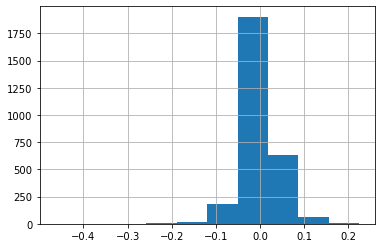

In [32]:
df.fwd_log_ret.hist()

<AxesSubplot:>

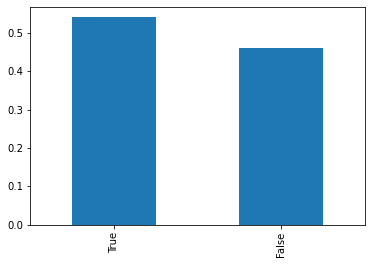

In [33]:
df.fwd_close_positive.value_counts(normalize=True).plot.bar()

### When volatility is high what kind of returns are expected? 
- Measure this using ATR:
    - TR = Max[(H-L), Abs(H-Cp), Abs(L-Cp)]
    - ATR = (1/n)* sum(TRi)

In [34]:
from talib import ATR

In [80]:
def perform_ATR_analysis(df, atr_threshold  = 0.75, alpha = 0.05):
    """Performs analysis of returns based on current vs historical ATR.
    
    If the difference in current and historical ATR is greater than the ATR threshold (quantile)"""

    # Calculate the 14 day ATR and add it as column to df
    df['ATR_14'] = ATR(df.high, df.low, df.close, 14)
    # Calculate the rolling 14 day average of ATR and add it as column to df
    df['avg_atr_14'] = df.ATR_14.rolling(14).mean()
    # Calculate the percentage current 14 day ATR is above/below the rolling mean
    df['atr_vs_historical'] = (df.ATR_14 - df.avg_atr_14)/df.avg_atr_14


    # Plot ATR 14 and close price
    fig, ax = plt.subplots(2,1,sharex=True)
    df.close.plot(ax = ax[0])
    ax[0].set_title('Close price of BTC')
    df.avg_atr_14.plot(ax = ax[1])
    ax[1].set_title('Rolling 14 day average of 14 day ATR')
    
    atr_threshold = df.atr_vs_historical.quantile(atr_threshold)

    df['atr_above_threshold'] = df.atr_vs_historical>atr_threshold

    print(f"Percentage of observations above threshold: {df.atr_above_threshold.mean():.2%}")
    
    print(f"Average next day return when ATR above threshold: {round(df[df.atr_above_threshold].fwd_log_ret.mean(),6)}")
    
    print(f"which is: {round(df[df.atr_above_threshold].fwd_log_ret.mean()/df.fwd_log_ret.mean(),3)} times overall average")
    
    # Perform one sample t-test -> is the average return of the high volatility days significantly greater than overall mean?
    
    t,p = stats.ttest_1samp(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret.mean())
    
    if ((t>0)&(p/2<alpha)):
        print("Results significant!: t is >0",t>0,"p/2 < alpha",p<alpha)
    else:
        print("Fail to reject null hypothesis")
    

Percentage of observations above threshold: 19.81%
Average next day return when ATR above threshold: 0.00492
which is: 3.31 times overall average
Results significant!: t is >0 True p/2 < alpha False


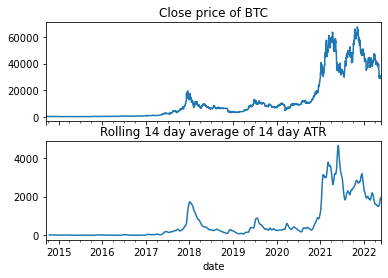

In [81]:
perform_ATR_analysis(df, atr_threshold = 0.8)

<AxesSubplot:xlabel='date'>

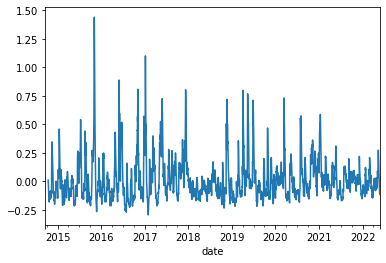

In [53]:
df.atr_vs_historical.plot()

When current ATR gets very extended from mean, what are next day returns?
- very extended defined as difference in current ATR from 14 day historical ATR as greater than the 3rd quartile

In [60]:
atr_threshold = df.atr_vs_historical.quantile(0.75)

df['atr_above_threshold'] = df.atr_vs_historical>atr_threshold

df.atr_above_threshold.mean()

As expected, the difference in current volatility from 14 day average is above threshold 25% of the time

What is the average return when (Current ATR - Historical ATR) > threshold? How does this compare with overall average?

In [62]:
df[df.atr_above_threshold].fwd_log_ret.mean()

0.004058148250319954

How does this compare to overall average?

In [65]:
df[df.atr_above_threshold].fwd_log_ret.mean()/df.fwd_log_ret.mean()

2.7296384679490866

Nearly 3 times as high as average. Check for statistical significance at the 95% confidence level:
- H0: Days with volatility above the threshold do not exhibit above average returns
- H1: Days with volatility above the threshold return in above average next day returns

In [69]:
alpha = 0.05
t,p = stats.ttest_1samp(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret.mean())

print("t is >0",t>0,"p/2 < alpha",p<alpha)

Cannot reject the null hypothesis - days with above average volatility do not result in above average next day returns. Will try additional thresholds

### Bollinger bands - when price is "stretched" a certain point from its average do we expect returns to be greater?

In [18]:
from talib import BBANDS

In [57]:
# Create 5 period sma as middle band, 2 std dev +- for upper and lower bands
df['upperband2'], df['middleband'], df['lowerband2'] = BBANDS(df.close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

df['upperband1'], df['middleband'], df['lowerband1'] = BBANDS(df.close, timeperiod=5, nbdevup=1, nbdevdn=1, matype=0)



# create columns true when low below lower band, another column true when high above upper band
df['low_below_lower1'] = df.low < df.lowerband1
df['high_above_upper1'] = df.high > df.upperband1

df['low_below_lower2'] = df.low < df.lowerband2
df['high_above_upper2'] = df.high > df.upperband2

In [59]:
df.low_below_lower1.mean()

0.46597791236195224

In [60]:
df.high_above_upper1.mean()

0.5553972212326327

What is the average forward return when low below lower and what is it when high above upper?

In [61]:
df[df.low_below_lower2].fwd_log_ret.mean()

5.468772458423057e-05

In [62]:
df[df.high_above_upper2].fwd_log_ret.mean()

0.00025614540533167523

In [63]:
df[df.low_below_lower1].fwd_log_ret.mean()

-0.0002509609606985909

In [64]:
df[df.high_above_upper1].fwd_log_ret.mean()

0.002590890403563458

In [30]:
df.fwd_log_ret.mean()

0.0014866980730122267

Overall the returns are much less than average when price is stretched 2 std dev away from the mean

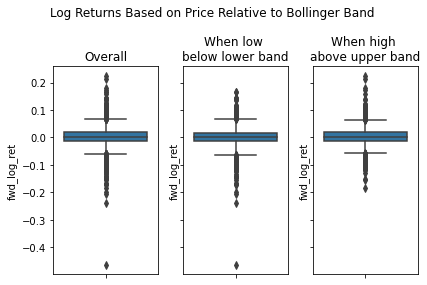

In [65]:
fig, ax = plt.subplots(1,3,sharey=True)
sns.boxplot(y=df.fwd_log_ret, ax = ax[0])
ax[0].set_title('Overall')
sns.boxplot(y=df[df.low_below_lower1].fwd_log_ret, ax=ax[1])
ax[1].set_title('When low \nbelow lower band')
sns.boxplot(y=df[df.high_above_upper1].fwd_log_ret, ax = ax[2])
ax[2].set_title('When high \nabove upper band')
plt.suptitle('Log Returns Based on Price Relative to Bollinger Band')
plt.tight_layout()

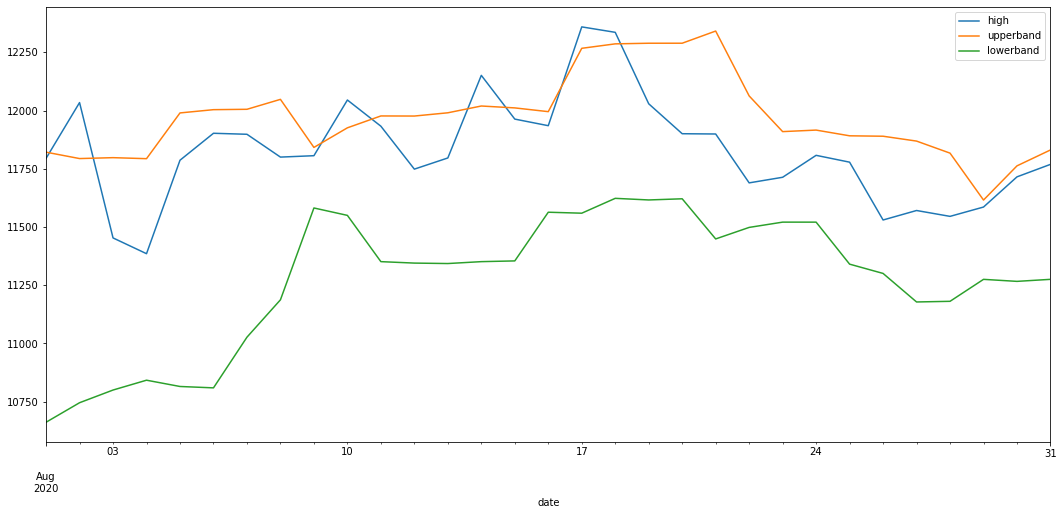

In [56]:
plt.figure(figsize = (18,8))
sample = df.loc['08-2020']
sample.high.plot()
sample.upperband.plot()
sample.lowerband.plot()
plt.legend()

Perform t-test

In [71]:
to_test = ['low_below_lower2', 'low_below_lower1', 'high_above_upper1', 'high_above_upper2']
overall_mean = df.fwd_log_ret.mean()
alpha = 0.05
for test in to_test:
    sample = df[df[test]].fwd_log_ret
    t,p = stats.ttest_1samp(sample, overall_mean)
    print(test, t, p/2<alpha)

low_below_lower2 -0.7212809213135888 False
low_below_lower1 -1.5194888178095236 False
high_above_upper1 1.201382924201341 False
high_above_upper2 -0.6961508741026569 False


Nothing significant

Explore consolidation then breakout of price